In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

from datetime import datetime
import datetime 

from tqdm import tqdm

from pypfopt.efficient_frontier import EfficientFrontier, EfficientCVaR, EfficientSemivariance, EfficientCDaR
from pypfopt import risk_models 
from pypfopt import expected_returns
from pypfopt import get_latest_prices
from pypfopt import DiscreteAllocation
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
from matplotlib.ticker import FuncFormatter

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 12})

In [2]:
import requests
import apimoex

In [3]:
df_of_bonds = pd.read_csv('bond_names_unskilled.txt')
list_of_bonds = df_of_bonds.bond_name

In [4]:
today_day = str(datetime.datetime.today().year) + '-' + str(datetime.datetime.today().month) + '-' + str(datetime.datetime.today().day)
today_day

'2023-10-31'

In [5]:
start_date_of_analysis =  datetime.datetime.now() - datetime.timedelta(days=0.5*365)
start_date_of_analysis = str(start_date_of_analysis.year) + '-' + str(start_date_of_analysis.month) + '-' + str(start_date_of_analysis.day)
start_date_of_analysis

'2023-5-1'

In [6]:
with requests.Session() as session:
    data = apimoex.get_board_history(session, str(list_of_bonds[0]), start_date_of_analysis, today_day, ('TRADEDATE', 'CLOSE'))
    df_stocks = pd.DataFrame(data).rename(columns={'TRADEDATE':'date', 'CLOSE':'price'})
    first_date = df_stocks.iloc[0].date

In [7]:
df_stocks = df_stocks.rename(columns={'price':str(list_of_bonds[0][:4])}).set_index('date')

In [8]:
list_of_prohibited_bonds = ['FEES', 'POLY', 'ABIO','TGKN', 'SVAV', 
                            'WUSH', 'ASTR', 'SOFL', 'ELFV', 'TRNFP', 
                            'TATNP', 'RTKMP', 'SBERP', 'SNGSP', 'MTLRP'
                           ]

In [9]:
for i in tqdm(range(1, len(list_of_bonds))):
    with requests.Session() as session:
        if str(list_of_bonds[i]) not in list_of_prohibited_bonds:
            data = apimoex.get_board_history(session, str(list_of_bonds[i]), start_date_of_analysis, today_day, ('TRADEDATE', 'CLOSE'))
            df = pd.DataFrame(data).rename(columns={'TRADEDATE':'date', 'CLOSE':'price'})
            if df.iloc[0].date == first_date:
                df = df.rename(columns={'price':str(list_of_bonds[i][:4])}).set_index('date')
                df_stocks = pd.concat([df_stocks, df], axis = 1)
            else:
                print(str(list_of_bonds[i][:4]))

100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:10<00:00,  8.54it/s]


In [10]:
df_stocks

,AKRN,ALRS,APTK,AMEZ,AFLT,VTBR,BSPB,VSMO,GAZP,LSRG,...,HHRU,MDMG,OKEY,OZON,QIWI,AGRO,TCSG,GEMC,FIVE,YNDX
date,,,,,,,,,,,,,,,,,,,,,
2023-05-02,19008,66.70,12.502,78.040,39.59,0.021880,174.94,50120,177.97,561.2,...,1543,539.3,30.56,1691.5,595.5,755.0,2679.0,396.0,1487.5,2015.0
2023-05-03,19000,65.40,12.556,77.015,38.02,0.020955,170.20,49620,172.87,534.2,...,1480,521.7,29.50,1620.0,566.5,723.2,2629.0,402.3,1412.0,1930.4
2023-05-04,19000,65.86,12.502,77.855,37.65,0.021095,172.20,49800,173.66,542.6,...,1511,532.8,29.67,1642.5,581.5,748.0,2652.5,394.5,1430.0,1979.6
2023-05-05,19000,64.79,12.440,76.510,37.12,0.021060,168.00,50700,172.09,541.0,...,1485,540.3,30.09,1609.0,583.0,750.0,2615.5,398.0,1408.5,1948.0
2023-05-08,19098,64.53,12.390,74.610,36.15,0.020690,139.89,51160,170.84,533.0,...,1464,533.8,30.17,1575.5,578.5,742.8,2610.0,391.8,1408.0,1943.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-24,18960,72.36,16.172,94.500,40.79,0.026615,258.01,42000,170.19,730.0,...,3778,861.3,36.17,2710.0,644.0,1650.0,3483.0,851.0,2401.0,2725.2
2023-10-25,19054,71.54,16.150,94.280,40.87,0.026395,257.60,42020,169.62,741.2,...,3762,854.3,36.70,2734.0,642.5,1601.6,3497.5,843.5,2414.5,2737.0
2023-10-26,19000,70.79,15.786,93.250,39.98,0.025550,253.59,41440,168.45,714.0,...,3700,828.1,35.71,2691.5,627.5,1502.2,3449.0,820.4,2372.0,2682.4


In [46]:
df_stocks.isna().sum().value_counts()

0    76
dtype: int64

In [47]:
df_stocks = df_stocks.dropna(how='any')

In [48]:
df_stocks.isna().sum().value_counts()

0    76
dtype: int64

In [49]:
#Годовая доходность
mu = expected_returns.mean_historical_return(df_stocks) 
historical_returns = expected_returns.returns_from_prices(df_stocks)
#Дисперсия портфеля
Sigma = risk_models.CovarianceShrinkage(df_stocks).ledoit_wolf()
#Максимальный коэффициент Шарпа
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
sharpe_pfolio=ef.max_sharpe() #May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt=ef.clean_weights()

In [50]:
list_of_w = list(sharpe_pwt)

In [51]:
list(set(list_of_bonds) - set(list_of_w) - set(list_of_prohibited_bonds))

[]

In [52]:
ef.portfolio_performance(verbose=True)

Expected annual return: 371.7%
Annual volatility: 23.7%
Sharpe Ratio: 15.57


(3.7167739442966643, 0.23747871928260544, 15.566758804595933)

In [53]:
ef1 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) 
minvol=ef1.min_volatility()
minvol_pwt=ef1.clean_weights()

In [54]:
ef1.portfolio_performance(verbose=True)

Expected annual return: 17.4%
Annual volatility: 10.6%
Sharpe Ratio: 1.46


(0.1741138932243772, 0.1056734435743562, 1.4583975690726527)

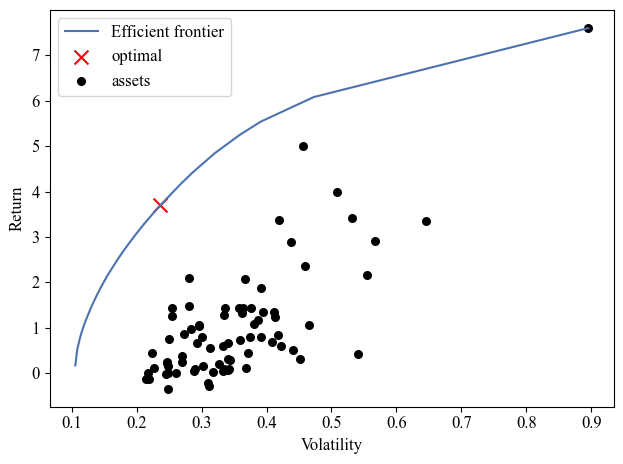

In [55]:
cl_obj = CLA(mu, Sigma)
ax = pplt.plot_efficient_frontier(cl_obj, showfig = True)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

<AxesSubplot:xlabel='Weight'>

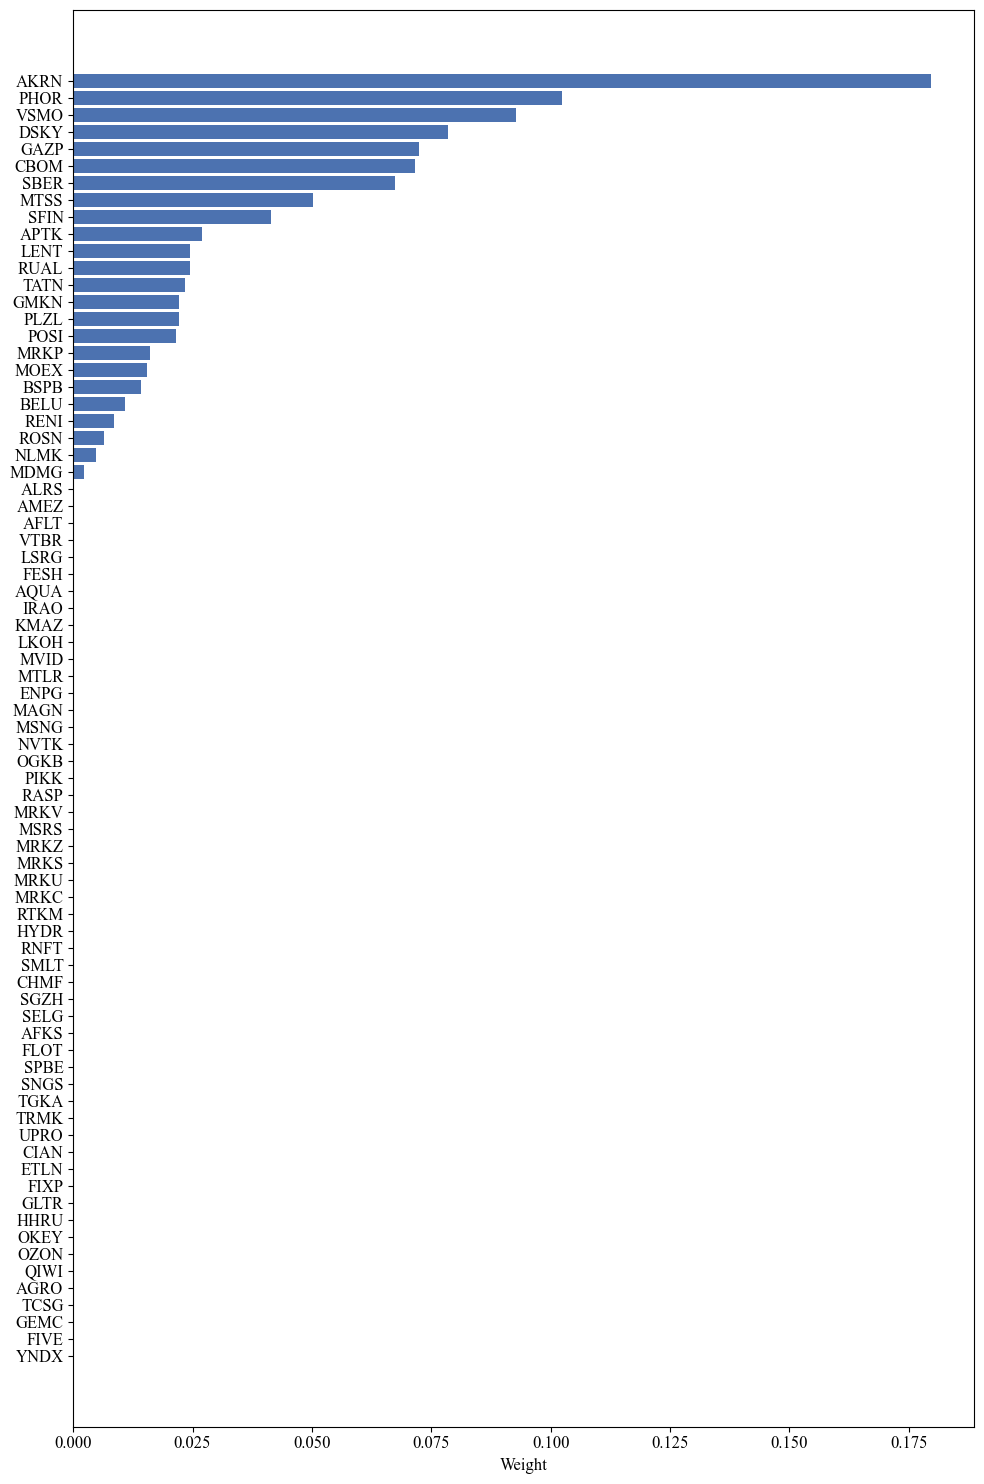

In [56]:
plt.figure(figsize=(10,15))
pplt.plot_weights(minvol_pwt)

In [60]:
amount_of_money_to_invest = 50_000

In [61]:
latest_prices = get_latest_prices(df_stocks)
allocation_minv, rem_minv = DiscreteAllocation(minvol_pwt, latest_prices, total_portfolio_value=amount_of_money_to_invest).greedy_portfolio() 
print(allocation_minv)
print("Осталось денежных средств после построения портфеля с минимальной волатильностью - {:.2f} рублей".format(rem_minv))
print()

{'AKRN': 1, 'DSKY': 55, 'GAZP': 22, 'CBOM': 496, 'SBER': 12, 'MTSS': 9, 'SFIN': 4, 'APTK': 85, 'LENT': 2, 'RUAL': 30, 'TATN': 2, 'POSI': 1, 'MRKP': 2316, 'MOEX': 4, 'BSPB': 3, 'RENI': 5, 'ROSN': 1, 'NLMK': 1, 'MDMG': 1}
Осталось денежных средств после построения портфеля с минимальной волатильностью - 7.02 рублей



In [62]:
latest_prices1 = get_latest_prices(df_stocks)
allocation_shp, rem_shp = DiscreteAllocation(sharpe_pwt, latest_prices1, total_portfolio_value=amount_of_money_to_invest).greedy_portfolio() 
print(allocation_shp)
print("Осталось денежных средств после построения портфеля с максимальным коэффициентом Шарпа {:.2f} рублей".format(rem_shp))

{'HHRU': 4, 'MOEX': 38, 'TRMK': 29, 'TATN': 7, 'MRKZ': 42989, 'FLOT': 36, 'GEMC': 3, 'AGRO': 2, 'DSKY': 30}
Осталось денежных средств после построения портфеля с максимальным коэффициентом Шарпа 1.45 рублей


In [63]:
from pypfopt import plotting

C:\Users\Stepan\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


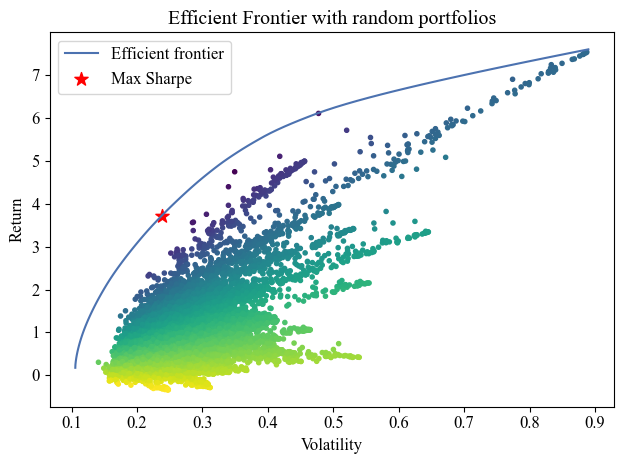

In [64]:
fig, ax = plt.subplots()
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 100_00
w = np.random.dirichlet(np.ones(ef.n_assets)*1e-2, n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

In [65]:
allocation_shp

{'HHRU': 4,
 'MOEX': 38,
 'TRMK': 29,
 'TATN': 7,
 'MRKZ': 42989,
 'FLOT': 36,
 'GEMC': 3,
 'AGRO': 2,
 'DSKY': 30}

In [67]:
allocation_minv

{'AKRN': 1,
 'DSKY': 55,
 'GAZP': 22,
 'CBOM': 496,
 'SBER': 12,
 'MTSS': 9,
 'SFIN': 4,
 'APTK': 85,
 'LENT': 2,
 'RUAL': 30,
 'TATN': 2,
 'POSI': 1,
 'MRKP': 2316,
 'MOEX': 4,
 'BSPB': 3,
 'RENI': 5,
 'ROSN': 1,
 'NLMK': 1,
 'MDMG': 1}

In [68]:
list_of_bonds_all = list(df_stocks.columns)
list_of_bonds_for_sharp = list(allocation_shp)
list_of_bonds_for_min = list(allocation_minv)

In [69]:
list_sigma_sharp = []
list_sigma_min = []
list_sigma_all = []
for i in range(len(list_of_bonds_for_sharp)):
    list_sigma_sharp.append((Sigma.loc[list_of_bonds_for_sharp[i]][list_of_bonds_for_sharp[i]])**(1/2))
    
for i in range(len(list_of_bonds_for_min)):
    list_sigma_min.append((Sigma.loc[list_of_bonds_for_min[i]][list_of_bonds_for_min[i]])**(1/2))
    
for i in range(len(list_of_bonds_all)):
    list_sigma_all.append((Sigma.loc[list_of_bonds_all[i]][list_of_bonds_all[i]])**(1/2))

In [70]:
df_of_sharp = pd.DataFrame({
    'bonds':list_of_bonds_for_sharp,
    'mu':np.array(mu[allocation_shp]),
    'sigma':np.array(list_sigma_sharp)
})

df_of_min = pd.DataFrame({
    'bonds':list_of_bonds_for_min,
    'mu':np.array(mu[allocation_minv]),
    'sigma':np.array(list_sigma_min)
})

df_of_all = pd.DataFrame({
    'bonds':list_of_bonds_all,
    'mu':np.array(mu),
    'sigma':np.array(list_sigma_all)
})

C:\Users\Stepan\AppData\Local\Temp\ipykernel_14528\3410566332.py:3: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  'mu':np.array(mu[allocation_shp]),
C:\Users\Stepan\AppData\Local\Temp\ipykernel_14528\3410566332.py:9: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  'mu':np.array(mu[allocation_minv]),


In [71]:
df_of_sharp

,bonds,mu,sigma
0,HHRU,4.995210,0.456291
1,MOEX,2.097637,0.279935
2,TRMK,3.985045,0.508857
3,TATN,1.429980,0.254039
4,MRKZ,7.602850,0.895384
5,FLOT,3.385327,0.419801
6,GEMC,3.415114,0.531249
7,AGRO,2.897524,0.437371
8,DSKY,0.066496,0.340658


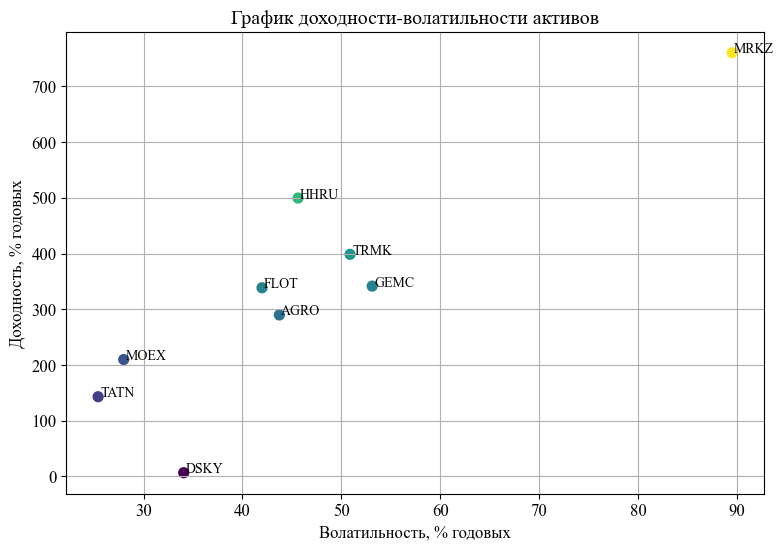

In [72]:
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(df_of_sharp.sigma*100, df_of_sharp.mu*100, c=df_of_sharp.mu*100, s=50)
ax.set_ylabel('Доходность, % годовых')
ax.set_xlabel('Волатильность, % годовых')
ax.set_title('График доходности-волатильности активов')
for idx, row in df_of_sharp.iterrows():
    ax.annotate(row['bonds'], (row['sigma']*100+0.2, row['mu']*100+0.2), fontsize=10) #row['bond_name']

plt.grid()
plt.show()

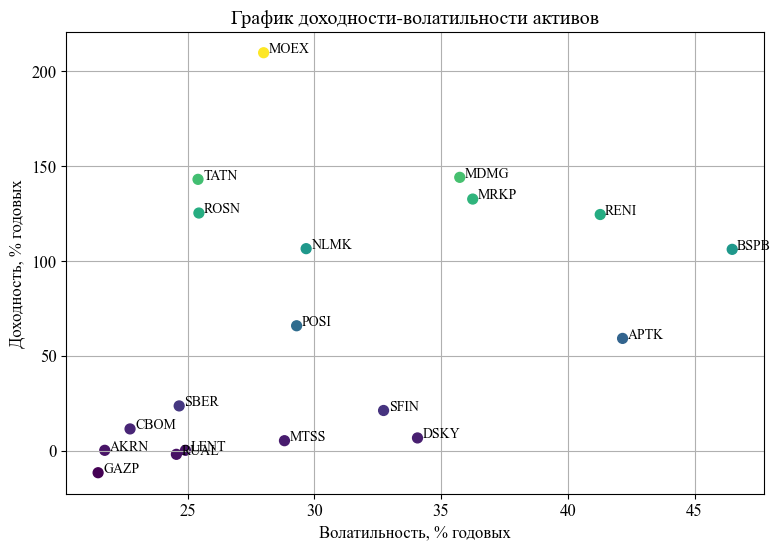

In [74]:
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(df_of_min.sigma*100, df_of_min.mu*100, c=df_of_min.mu*100, s=50)
ax.set_ylabel('Доходность, % годовых')
ax.set_xlabel('Волатильность, % годовых')
ax.set_title('График доходности-волатильности активов')
for idx, row in df_of_min.iterrows():
    ax.annotate(row['bonds'], (row['sigma']*100+0.2, row['mu']*100+0.2), fontsize=10) #row['bond_name']

plt.grid()
plt.show()

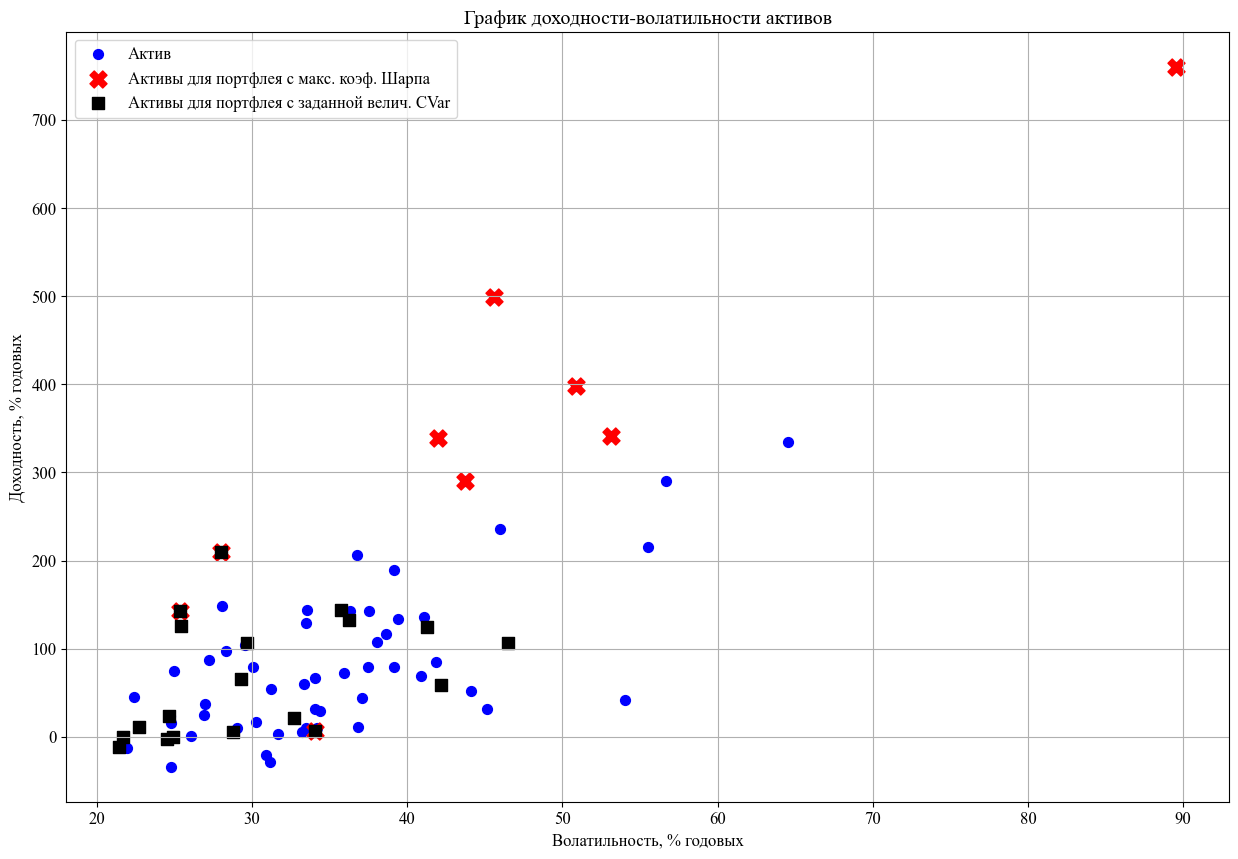

In [73]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(df_of_all.sigma*100, df_of_all.mu*100, s=50, color='blue', label='Актив')
ax.scatter(df_of_sharp.sigma*100, df_of_sharp.mu*100, c='red', s=150, marker='X', label='Активы для портфлея с макс. коэф. Шарпа')
ax.scatter(df_of_min.sigma*100, df_of_min.mu*100, s=80, marker='s', color='black', label='Активы для портфлея с заданной велич. CVar')
ax.set_ylabel('Доходность, % годовых')
ax.set_xlabel('Волатильность, % годовых')
ax.set_title('График доходности-волатильности активов')
# for idx, row in df_of_all.iterrows():
#     ax.annotate(row['bonds'], (row['sigma']*100+0.2, row['mu']*100+0.2), fontsize=10) #row['bond_name']

plt.grid()
plt.legend()
plt.show()